In [1]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np

import copy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_dir = "/kaggle/input/ham10kfolds10dataset-224x224/Fold4/train"
val_dir = "/kaggle/input/ham10kfolds10dataset-224x224/Fold4/test"
test_dir = "/kaggle/input/ham10kfolds10dataset-224x224/Fold4/test"

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in validation dataset:", len(val_dataset))
print("Number of images in test dataset:", len(test_dataset))


Number of images in train dataset: 9013
Number of images in validation dataset: 1002
Number of images in test dataset: 1002


In [5]:
num_classes = len(train_dataset.classes)

In [6]:
class ChannelGate(nn.Module):
    def __init__(self, channel, reduction=8, dropout_ratio=0.02):
        super(ChannelGate, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),  # Adding dropout
            nn.Linear(channel // reduction, channel, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.fc(self.max_pool(x).view(x.size(0), -1))
        out = self.sigmoid(avg_out + max_out).unsqueeze(2).unsqueeze(3)
        return out * x  # Element-wise multiplication with input


class SpatialGate(nn.Module):
    def __init__(self, dropout_ratio=0.02):
        super(SpatialGate, self).__init__()
        kernel_size = 3
        self.compress = ChannelPool()
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2),
            nn.Dropout(dropout_ratio)  # Adding dropout
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = self.sigmoid(x_out)  # broadcasting
        return x * scale


class ChannelPool(nn.Module):
    def __init__(self):
        super(ChannelPool, self).__init__()

    def forward(self, x):
        x_max = torch.max(x, 1, keepdim=True)[0]
        x_avg = torch.mean(x, 1, keepdim=True)
        x_pool = torch.cat([x_max, x_avg], dim=1)
        return x_pool


class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=8, dropout_ratio=0.02):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, dropout_ratio)
        self.SpatialGate = SpatialGate(dropout_ratio)

    def forward(self, x):
        return self.SpatialGate(self.ChannelGate(x))


In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, ks, dropout_ratio=0.02):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=ks, stride=1,
                              padding=(ks - 1) // 2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class ZPool(nn.Module):
    def forward(self, x):
        x_mean = x.mean(dim=1, keepdim=True)
        x_max = x.max(dim=1, keepdim=True)[0]
        return torch.cat([x_mean, x_max], dim=1)

class AttentionGate(nn.Module):
    def __init__(self, kernel_size=3, dropout_ratio=0.02):
        super().__init__()
        self.compress = ZPool()
        self.conv = BasicConv2d(2, 1, kernel_size, dropout_ratio)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        y = self.compress(x)
        y = self.conv(y)
        y = self.activation(y)
        return x * y
    
class TripletAttention(nn.Module):
    def __init__(self, kernel_size=3, dropout_ratio=0.02):
        super().__init__()
        self.ch = AttentionGate(kernel_size, dropout_ratio)
        self.cw = AttentionGate(kernel_size, dropout_ratio)
        self.hw = AttentionGate(kernel_size, dropout_ratio)

    def forward(self, x):
        b, c, h, w = x.shape
        x_ch = self.ch(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1) # c and h
        x_cw = self.cw(x.permute(0, 2, 1, 3)).permute(0, 2, 1, 3)
        x_hw = self.hw(x)
        return 1 / 3 * (x_ch + x_cw + x_hw)


In [8]:
class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        
        base_model1 = models.densenet201(pretrained=True)

        self.base_model1= nn.Sequential(*list(base_model1.features.children())) # Remove the last two layers
       
        self.bn1 = nn.BatchNorm2d(1920)
        
        self.bn = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(0.02)
    
        # Separable convolution layers for each branch
        self.sep_conv11 = nn.Sequential(
            nn.Conv2d(1920, 512, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.02)
        )
        
        self.sep_conv12 = nn.Sequential(
            nn.Conv2d(1920, 512, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.02)
        )
        
        self.sep_conv13 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(512),
            nn.Dropout(0.02)
        )
        
        self.sep_conv4 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.02)
        )
        
        self.cbam1 = CBAM(512)
        self.cbam2 = CBAM(512)
        
        self.triplet_attention1 = TripletAttention(kernel_size=3) 
        self.triplet_attention2 = TripletAttention(kernel_size=3) 
    
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers for each branch
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        features = self.get_features(x)
        return self.classify(features)

    def get_features(self, x):
        
        x1 = self.base_model1(x)
        #rint("x1_after_basemodel1", x1.shape)
        x1 = self.bn1(x1)
        x1 = self.dropout(x1)
        #rint("x1", x1.shape)
        
        x_sep11 = self.sep_conv11(x1)
        #rint("x_sep11", x_sep11.shape)
        x_cbam11 = self.cbam1(x_sep11)
        #rint("x1_cbam11", x_cbam11.shape)
        x11 = torch.cat([x_sep11, x_cbam11], dim=1)
        #rint("x11", x11.shape)
        x_sep_mul11 = self.sep_conv13(x11)
        #rint("x_sep_mul11", x_sep_mul11.shape)
        x_cbam12 = self.cbam2(x_sep_mul11)
        x12 = torch.cat([x_sep11, x_cbam12], dim=1)
        
        x_sep12 = self.sep_conv12(x1)
        #rint("x_sep12", x_sep12.shape)
        x_triplate11 = self.triplet_attention1(x_sep12)
        #rint("x_triplate11", x_triplate11.shape)
        x21 = torch.cat([x_sep12, x_triplate11], dim = 1)
        #rint("x12", x12.shape)
        x_sep_mul12 = self.sep_conv13(x21)
        #rint("x_sep_mul12", x_sep_mul12.shape)
        x_triplate12 = self.triplet_attention2(x_sep_mul12)
        x22 = torch.cat([x_sep12, x_triplate12], dim = 1)

        final_x = torch.mul(x12,  x22)
        #rint("final_x1", final_x1.shape)
        final_x = self.dropout(final_x)
        #rint("first_half_done")
        
        x_sep = self.sep_conv4(final_x)
        #print("x_sep", x_sep.shape)
        x = self.bn(x_sep)
        
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        return x
    
    def classify(self, features):
        return self.fc(features)

In [9]:
def calculate_metrics(labels, preds):
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return precision, recall, f1

In [10]:
def calculate_specificity_sensitivity(labels, preds):
    """Calculate sensitivity and specificity."""
    cfm = confusion_matrix(labels, preds)
    TP = cfm[1, 1]
    TN = cfm[0, 0]
    FP = cfm[0, 1]
    FN = cfm[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Avoid division by zero

    return sensitivity, specificity

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(train_values, val_values, title, ylabel):
    plt.figure(figsize=(6, 4))  # Set the figure size
    plt.style.use('seaborn')  # Set the plot style
    plt.title(title, fontsize=16, fontweight='bold')  # Set the title
    plt.plot(train_values, label='Training', color='blue', linewidth=2)  # Plot training values
    plt.plot(val_values, label='Validation', color='orange', linewidth=2)  # Plot validation values
    plt.xlabel('Epochs', fontsize=14)  # Set the x-label
    plt.ylabel(ylabel, fontsize=14)  # Set the y-label
    plt.legend(fontsize=12)  # Add legend
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()  # Show the plot

In [12]:
def extract_features_and_labels(model, data_loader, device):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for images, batch_labels in tqdm(data_loader, desc="Extracting Features"):
            images = images.to(device)
            batch_labels = batch_labels.to(device)
            images = F.interpolate(images, size=(224, 224), mode='bilinear', align_corners=False)
            if isinstance(model, nn.DataParallel):
                output_features = model.module.get_features(images)
            else:
                output_features = model.get_features(images)
            features.extend(output_features.cpu().numpy())
            labels.extend(batch_labels.cpu().numpy())

    return {'features': np.array(features), 'labels': np.array(labels)}

In [13]:
class CustomLoss(nn.Module):
    def __init__(self, num_classes):
        super(CustomLoss, self).__init__()
        self.num_classes = num_classes
        self.initial_alpha = 0.6
        self.initial_gamma = 3
        self.initial_ce_weight = 0.2
        self.initial_focal_weight = 0.9
        self.initial_smoothing = 0.1

    def forward(self, output, target, current_epoch, total_epochs):
        # Dynamic adjustments based on the epoch number
        decay_factor = current_epoch / total_epochs
        alpha = self.initial_alpha * (1 - decay_factor)  # Decrease alpha over time
        gamma = self.initial_gamma * (1 - decay_factor)  # Decrease gamma over time
        ce_weight = self.initial_ce_weight  # Could also be adjusted dynamically
        focal_weight = self.initial_focal_weight * (1 - decay_factor)  # Decrease focal weight
        smoothing = self.initial_smoothing * (1 - decay_factor)  # Decrease smoothing

        # Adjust class weights based on the frequency of each class
        class_counts = torch.zeros(self.num_classes, device=output.device)
        for c in range(self.num_classes):
            class_counts[c] = (target == c).sum()

        epsilon = 1e-6
        class_weights = 1.0 / (class_counts + epsilon)
        class_weights = class_weights / class_weights.sum()  # normalize to sum to 1

        # Compute log probabilities
        log_probs = F.log_softmax(output, dim=1)

        # Apply label smoothing
        true_dist = torch.zeros_like(log_probs)
        true_dist.fill_(smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.unsqueeze(1), 1 - smoothing)

        # Compute the cross-entropy loss with label smoothing
        ce_loss = torch.mean(torch.sum(-true_dist * log_probs, dim=1))

        # Compute the focal component
        pt = torch.exp(-ce_loss)
        focal_loss = alpha * (1 - pt) ** gamma * ce_loss

        # Combine the losses with respective weights
        total_loss = ce_weight * ce_loss + focal_weight * focal_loss

        return total_loss

In [14]:
def snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device):
    
    ensemble_models = []
    snapshot_epochs = [30, 70, 120]  # Adjusted snapshot epochs
    best_snapshot_weights = None

    model = CustomModel(num_classes).to(device)
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)       
    
    criterion =  CustomLoss(num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = CosineAnnealingLR(optimizer, T_max=snapshot_epochs[0], eta_min=1e-8)
    
    train_accs, val_accs, train_losses, val_losses, test_accs, test_losses = [], [], [], [], [], []
    learning_rates = []

    total_epochs = 120
    
    best_val_accuracy = 0

    for epoch in range(total_epochs):
        if epoch in snapshot_epochs and epoch != snapshot_epochs[-1]:
            optimizer = optim.Adam(model.parameters(), lr=0.0001)
            next_snapshot_index = snapshot_epochs.index(epoch) + 1
            epochs_until_next_snapshot = snapshot_epochs[next_snapshot_index] - epoch
            scheduler = CosineAnnealingLR(optimizer, T_max=epochs_until_next_snapshot, eta_min=1e-8)
            
        lr_rate = optimizer.param_groups[0]['lr']
        learning_rates.append(lr_rate)
        print(f"Epoch {epoch + 1}/120, Learning Rate: {lr_rate}")

        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds = []
        train_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/120"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels, epoch, total_epochs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_accuracy = train_correct / train_total
        train_accs.append(train_accuracy)
        train_losses.append(train_loss / train_total)
        
        train_precision = precision_score(train_labels, train_preds, average='weighted')
        train_recall = recall_score(train_labels, train_preds, average='weighted')
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        print(f"Train Loss: {train_loss / train_total:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1 Score: {train_f1:.4f}")


        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels, epoch, total_epochs)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())


        val_accuracy = val_correct / val_total
        val_accs.append(val_accuracy)
        val_losses.append(val_loss / val_total)
        
        val_precision = precision_score(val_labels, val_preds, average='weighted')
        val_recall = recall_score(val_labels, val_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        print(f"Validation Loss: {val_loss / val_total:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1 Score: {val_f1:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_snapshot_weights = copy.deepcopy(model.state_dict())
            print("Best model updated based on validation accuracy")

        if epoch + 1 in snapshot_epochs:
            
            snapshot_count = snapshot_epochs.index(epoch + 1)
            ensemble_models.append(copy.deepcopy(model))
            torch.save(model.state_dict(), f'snapshot_{snapshot_count}_model.pth')
            print(f"Snapshot {snapshot_count} saved")

            # Evaluate using the best model up to this snapshot
            model.load_state_dict(best_snapshot_weights)
            test_loss = 0
            test_correct = 0
            test_total = 0
            test_preds = []
            test_labels = []
            test_probs = []

            with torch.no_grad():
                for images, labels in tqdm(test_loader, desc="Testing"):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels, epoch, total_epochs)
                    test_loss += loss.item() * labels.size(0)
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()
                    test_preds.extend(predicted.cpu().numpy())
                    test_labels.extend(labels.cpu().numpy())
                    test_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

            test_accuracy = test_correct / test_total
            test_accs.append(test_accuracy)
            test_losses.append(test_loss / test_total)
            
            test_accuracy = test_correct / test_total
            test_precision = precision_score(test_labels, test_preds, average='weighted')
            test_recall = recall_score(test_labels, test_preds, average='weighted')
            test_f1 = f1_score(test_labels, test_preds, average='weighted')
            print(f"Test Loss: {test_loss / test_total:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")

            print("Classification Report for Test Data:")
            print(classification_report(test_labels, test_preds))
            
            # Inside the loop where you evaluate the model on the test set
            conf_matrix = confusion_matrix(test_labels, test_preds)
            
            # Calculate percentages
            conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

            # Plot confusion matrix
            plt.figure(figsize=(6, 4))
            sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

            sensitivity, specificity = calculate_specificity_sensitivity(test_labels, test_preds)
            print(f"Test Sensitivity: {sensitivity:.4f}, Test Specificity: {specificity:.4f}")

            # Plot accuracy and loss curves
            plot_metrics(train_accs, val_accs, 'Accuracy vs. Epochs', 'Accuracy')
            plot_metrics(train_losses, val_losses, 'Loss vs. Epochs', 'Loss')
            
            # Plot learning rate curve
            plt.figure(figsize=(6, 4))
            plt.plot(range(1, epoch + 2), learning_rates)
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.title('Learning Rate vs. Epochs')
            plt.grid(True)
            plt.show()

            # Extract and save features for train, validation, and test sets
            train_features_and_labels = extract_features_and_labels(model, train_loader, device)
            val_features_and_labels = extract_features_and_labels(model, val_loader, device)
            test_features_and_labels = extract_features_and_labels(model, test_loader, device)
            
            torch.save(train_features_and_labels, f'snapshot_{snapshot_count}_train_features.pth')
            torch.save(val_features_and_labels, f'snapshot_{snapshot_count}_val_features.pth')
            torch.save(test_features_and_labels, f'snapshot_{snapshot_count}_test_features.pth')

        scheduler.step()

    return ensemble_models

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 93.3MB/s]


Using 2 GPUs!
Epoch 1/120, Learning Rate: 0.0001


Epoch 1/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.4625, Train Accuracy: 0.7526, Train Precision: 0.7566, Train Recall: 0.7526, Train F1 Score: 0.7539


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.5471, Validation Accuracy: 0.7894, Validation Precision: 0.8389, Validation Recall: 0.7894, Validation F1 Score: 0.7902
Best model updated based on validation accuracy
Epoch 2/120, Learning Rate: 9.972612215893683e-05


Epoch 2/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.2182, Train Accuracy: 0.9114, Train Precision: 0.9090, Train Recall: 0.9114, Train F1 Score: 0.9096


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2770, Validation Accuracy: 0.8633, Validation Precision: 0.8638, Validation Recall: 0.8633, Validation F1 Score: 0.8624
Best model updated based on validation accuracy
Epoch 3/120, Learning Rate: 9.890748929868662e-05


Epoch 3/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1584, Train Accuracy: 0.9777, Train Precision: 0.9776, Train Recall: 0.9777, Train F1 Score: 0.9776


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2451, Validation Accuracy: 0.8882, Validation Precision: 0.8855, Validation Recall: 0.8882, Validation F1 Score: 0.8844
Best model updated based on validation accuracy
Epoch 4/120, Learning Rate: 9.755307053217622e-05


Epoch 4/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1389, Train Accuracy: 0.9972, Train Precision: 0.9972, Train Recall: 0.9972, Train F1 Score: 0.9972


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2447, Validation Accuracy: 0.8852, Validation Precision: 0.8810, Validation Recall: 0.8852, Validation F1 Score: 0.8814
Epoch 5/120, Learning Rate: 9.567770515484182e-05


Epoch 5/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1335, Train Accuracy: 0.9989, Train Precision: 0.9989, Train Recall: 0.9989, Train F1 Score: 0.9989


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2479, Validation Accuracy: 0.8852, Validation Precision: 0.8825, Validation Recall: 0.8852, Validation F1 Score: 0.8795
Epoch 6/120, Learning Rate: 9.330194006220303e-05


Epoch 6/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1297, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2401, Validation Accuracy: 0.8912, Validation Precision: 0.8884, Validation Recall: 0.8912, Validation F1 Score: 0.8876
Best model updated based on validation accuracy
Epoch 7/120, Learning Rate: 9.045180463377551e-05


Epoch 7/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1276, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2325, Validation Accuracy: 0.8932, Validation Precision: 0.8909, Validation Recall: 0.8932, Validation F1 Score: 0.8904
Best model updated based on validation accuracy
Epoch 8/120, Learning Rate: 8.715852554974232e-05


Epoch 8/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1255, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2416, Validation Accuracy: 0.8822, Validation Precision: 0.8801, Validation Recall: 0.8822, Validation F1 Score: 0.8799
Epoch 9/120, Learning Rate: 8.345818466491112e-05


Epoch 9/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1238, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2353, Validation Accuracy: 0.8912, Validation Precision: 0.8878, Validation Recall: 0.8912, Validation F1 Score: 0.8888
Epoch 10/120, Learning Rate: 7.939132368836219e-05


Epoch 10/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1226, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2289, Validation Accuracy: 0.8842, Validation Precision: 0.8806, Validation Recall: 0.8842, Validation F1 Score: 0.8801
Epoch 11/120, Learning Rate: 7.500249999999999e-05


Epoch 11/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1209, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2350, Validation Accuracy: 0.8852, Validation Precision: 0.8827, Validation Recall: 0.8852, Validation F1 Score: 0.8808
Epoch 12/120, Learning Rate: 7.033979847057463e-05


Epoch 12/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1195, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2327, Validation Accuracy: 0.8862, Validation Precision: 0.8820, Validation Recall: 0.8862, Validation F1 Score: 0.8821
Epoch 13/120, Learning Rate: 6.54543046337755e-05


Epoch 13/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1182, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2269, Validation Accuracy: 0.8852, Validation Precision: 0.8825, Validation Recall: 0.8852, Validation F1 Score: 0.8823
Epoch 14/120, Learning Rate: 6.039954498243388e-05


Epoch 14/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1169, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2302, Validation Accuracy: 0.8782, Validation Precision: 0.8728, Validation Recall: 0.8782, Validation F1 Score: 0.8715
Epoch 15/120, Learning Rate: 5.5230900521066344e-05


Epoch 15/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1156, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2245, Validation Accuracy: 0.8922, Validation Precision: 0.8910, Validation Recall: 0.8922, Validation F1 Score: 0.8904
Epoch 16/120, Learning Rate: 5.000500000000001e-05


Epoch 16/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1143, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2240, Validation Accuracy: 0.8872, Validation Precision: 0.8837, Validation Recall: 0.8872, Validation F1 Score: 0.8830
Epoch 17/120, Learning Rate: 4.4779099478933676e-05


Epoch 17/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1132, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2240, Validation Accuracy: 0.8842, Validation Precision: 0.8836, Validation Recall: 0.8842, Validation F1 Score: 0.8813
Epoch 18/120, Learning Rate: 3.961045501756612e-05


Epoch 18/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1121, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2236, Validation Accuracy: 0.8802, Validation Precision: 0.8772, Validation Recall: 0.8802, Validation F1 Score: 0.8750
Epoch 19/120, Learning Rate: 3.455569536622451e-05


Epoch 19/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1111, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2198, Validation Accuracy: 0.8892, Validation Precision: 0.8871, Validation Recall: 0.8892, Validation F1 Score: 0.8860
Epoch 20/120, Learning Rate: 2.967020152942538e-05


Epoch 20/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1097, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2159, Validation Accuracy: 0.8912, Validation Precision: 0.8893, Validation Recall: 0.8912, Validation F1 Score: 0.8882
Epoch 21/120, Learning Rate: 2.5007500000000014e-05


Epoch 21/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1087, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2176, Validation Accuracy: 0.8852, Validation Precision: 0.8835, Validation Recall: 0.8852, Validation F1 Score: 0.8807
Epoch 22/120, Learning Rate: 2.0618676311637815e-05


Epoch 22/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1075, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2141, Validation Accuracy: 0.8922, Validation Precision: 0.8897, Validation Recall: 0.8922, Validation F1 Score: 0.8895
Epoch 23/120, Learning Rate: 1.6551815335088904e-05


Epoch 23/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1063, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2112, Validation Accuracy: 0.8942, Validation Precision: 0.8913, Validation Recall: 0.8942, Validation F1 Score: 0.8911
Best model updated based on validation accuracy
Epoch 24/120, Learning Rate: 1.285147445025769e-05


Epoch 24/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1054, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2150, Validation Accuracy: 0.8842, Validation Precision: 0.8839, Validation Recall: 0.8842, Validation F1 Score: 0.8803
Epoch 25/120, Learning Rate: 9.558195366224511e-06


Epoch 25/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1043, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2111, Validation Accuracy: 0.8872, Validation Precision: 0.8851, Validation Recall: 0.8872, Validation F1 Score: 0.8837
Epoch 26/120, Learning Rate: 6.7080599377969894e-06


Epoch 26/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1033, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2086, Validation Accuracy: 0.8902, Validation Precision: 0.8866, Validation Recall: 0.8902, Validation F1 Score: 0.8866
Epoch 27/120, Learning Rate: 4.3322948451581655e-06


Epoch 27/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1022, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2068, Validation Accuracy: 0.8922, Validation Precision: 0.8906, Validation Recall: 0.8922, Validation F1 Score: 0.8889
Epoch 28/120, Learning Rate: 2.4569294678237997e-06


Epoch 28/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1012, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2069, Validation Accuracy: 0.8902, Validation Precision: 0.8896, Validation Recall: 0.8902, Validation F1 Score: 0.8868
Epoch 29/120, Learning Rate: 1.1025107013133848e-06


Epoch 29/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1001, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2044, Validation Accuracy: 0.8932, Validation Precision: 0.8917, Validation Recall: 0.8932, Validation F1 Score: 0.8908
Epoch 30/120, Learning Rate: 2.838778410631714e-07


Epoch 30/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0991, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2024, Validation Accuracy: 0.8892, Validation Precision: 0.8875, Validation Recall: 0.8892, Validation F1 Score: 0.8856
Snapshot 0 saved


Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.2004, Test Accuracy: 0.8942, Test Precision: 0.8913, Test Recall: 0.8942, Test F1 Score: 0.8911
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        33
           1       0.87      0.78      0.82        51
           2       0.88      0.74      0.80       110
           3       0.89      0.67      0.76        12
           4       0.73      0.68      0.71       111
           5       0.93      0.98      0.95       670
           6       1.00      0.93      0.97        15

    accuracy                           0.89      1002
   macro avg       0.87      0.78      0.82      1002
weighted avg       0.89      0.89      0.89      1002



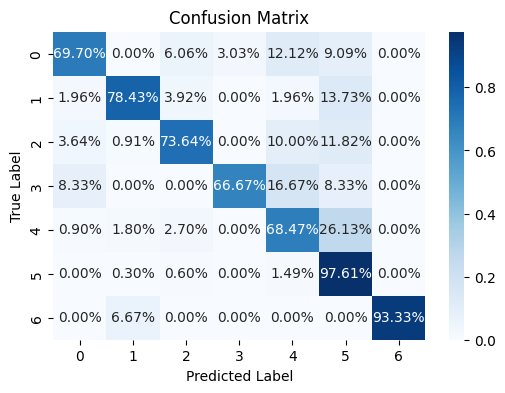

Test Sensitivity: 0.9756, Test Specificity: 1.0000


<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


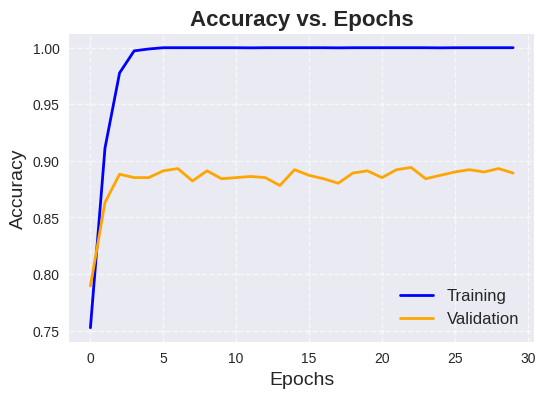

<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


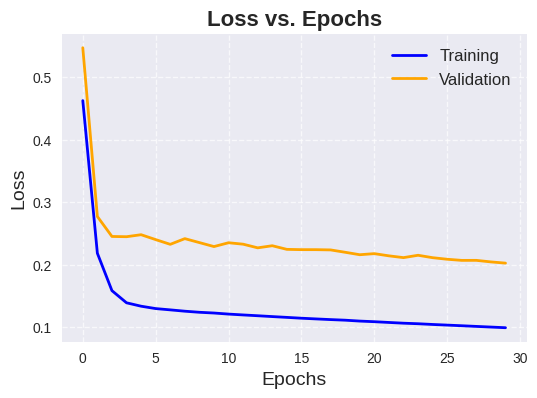

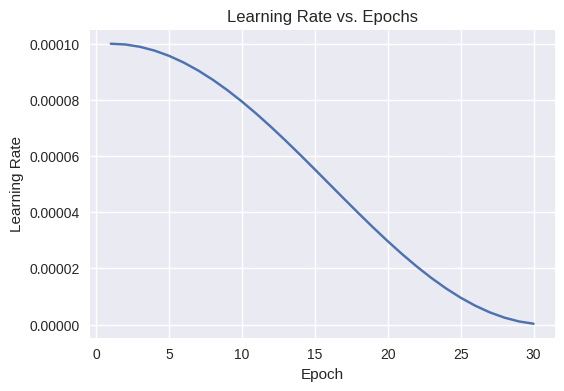

Extracting Features:   0%|          | 0/71 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31/120, Learning Rate: 0.0001


Epoch 31/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1139, Train Accuracy: 0.9840, Train Precision: 0.9840, Train Recall: 0.9840, Train F1 Score: 0.9840


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2820, Validation Accuracy: 0.8493, Validation Precision: 0.8556, Validation Recall: 0.8493, Validation F1 Score: 0.8506
Epoch 32/120, Learning Rate: 9.984588209998774e-05


Epoch 32/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1194, Train Accuracy: 0.9720, Train Precision: 0.9719, Train Recall: 0.9720, Train F1 Score: 0.9719


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2394, Validation Accuracy: 0.8623, Validation Precision: 0.8599, Validation Recall: 0.8623, Validation F1 Score: 0.8557
Epoch 33/120, Learning Rate: 9.938447858805392e-05


Epoch 33/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.1088, Train Accuracy: 0.9874, Train Precision: 0.9873, Train Recall: 0.9874, Train F1 Score: 0.9873


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2106, Validation Accuracy: 0.8772, Validation Precision: 0.8768, Validation Recall: 0.8772, Validation F1 Score: 0.8740
Epoch 34/120, Learning Rate: 9.861863417028185e-05


Epoch 34/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0994, Train Accuracy: 0.9964, Train Precision: 0.9965, Train Recall: 0.9964, Train F1 Score: 0.9964


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1969, Validation Accuracy: 0.8902, Validation Precision: 0.8869, Validation Recall: 0.8902, Validation F1 Score: 0.8877
Epoch 35/120, Learning Rate: 9.755307053217622e-05


Epoch 35/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0957, Train Accuracy: 0.9992, Train Precision: 0.9992, Train Recall: 0.9992, Train F1 Score: 0.9992


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2007, Validation Accuracy: 0.8872, Validation Precision: 0.8885, Validation Recall: 0.8872, Validation F1 Score: 0.8846
Epoch 36/120, Learning Rate: 9.619435722790178e-05


Epoch 36/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0940, Train Accuracy: 0.9993, Train Precision: 0.9993, Train Recall: 0.9993, Train F1 Score: 0.9993


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1964, Validation Accuracy: 0.8832, Validation Precision: 0.8858, Validation Recall: 0.8832, Validation F1 Score: 0.8806
Epoch 37/120, Learning Rate: 9.455087117679744e-05


Epoch 37/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0925, Train Accuracy: 0.9991, Train Precision: 0.9991, Train Recall: 0.9991, Train F1 Score: 0.9991


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1955, Validation Accuracy: 0.8832, Validation Precision: 0.8815, Validation Recall: 0.8832, Validation F1 Score: 0.8817
Epoch 38/120, Learning Rate: 9.263274501688284e-05


Epoch 38/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0914, Train Accuracy: 0.9986, Train Precision: 0.9986, Train Recall: 0.9986, Train F1 Score: 0.9986


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2062, Validation Accuracy: 0.8713, Validation Precision: 0.8745, Validation Recall: 0.8713, Validation F1 Score: 0.8722
Epoch 39/120, Learning Rate: 9.04518046337755e-05


Epoch 39/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0917, Train Accuracy: 0.9966, Train Precision: 0.9966, Train Recall: 0.9966, Train F1 Score: 0.9966


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2295, Validation Accuracy: 0.8633, Validation Precision: 0.8626, Validation Recall: 0.8633, Validation F1 Score: 0.8587
Epoch 40/120, Learning Rate: 8.802149625017354e-05


Epoch 40/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0913, Train Accuracy: 0.9960, Train Precision: 0.9960, Train Recall: 0.9960, Train F1 Score: 0.9960


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2094, Validation Accuracy: 0.8733, Validation Precision: 0.8696, Validation Recall: 0.8733, Validation F1 Score: 0.8693
Epoch 41/120, Learning Rate: 8.535680352542143e-05


Epoch 41/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0898, Train Accuracy: 0.9958, Train Precision: 0.9958, Train Recall: 0.9958, Train F1 Score: 0.9958


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1940, Validation Accuracy: 0.8743, Validation Precision: 0.8736, Validation Recall: 0.8743, Validation F1 Score: 0.8733
Epoch 42/120, Learning Rate: 8.247415517626753e-05


Epoch 42/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0889, Train Accuracy: 0.9962, Train Precision: 0.9962, Train Recall: 0.9962, Train F1 Score: 0.9962


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.2206, Validation Accuracy: 0.8573, Validation Precision: 0.8551, Validation Recall: 0.8573, Validation F1 Score: 0.8531
Epoch 43/120, Learning Rate: 7.939132368836218e-05


Epoch 43/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0886, Train Accuracy: 0.9946, Train Precision: 0.9946, Train Recall: 0.9946, Train F1 Score: 0.9946


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1983, Validation Accuracy: 0.8752, Validation Precision: 0.8739, Validation Recall: 0.8752, Validation F1 Score: 0.8733
Epoch 44/120, Learning Rate: 7.612731574297384e-05


Epoch 44/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0860, Train Accuracy: 0.9967, Train Precision: 0.9967, Train Recall: 0.9967, Train F1 Score: 0.9967


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1969, Validation Accuracy: 0.8743, Validation Precision: 0.8749, Validation Recall: 0.8743, Validation F1 Score: 0.8733
Epoch 45/120, Learning Rate: 7.270225503447863e-05


Epoch 45/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0860, Train Accuracy: 0.9956, Train Precision: 0.9956, Train Recall: 0.9956, Train F1 Score: 0.9956


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1900, Validation Accuracy: 0.8842, Validation Precision: 0.8794, Validation Recall: 0.8842, Validation F1 Score: 0.8794
Epoch 46/120, Learning Rate: 6.913725820109265e-05


Epoch 46/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0825, Train Accuracy: 0.9981, Train Precision: 0.9981, Train Recall: 0.9981, Train F1 Score: 0.9981


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1743, Validation Accuracy: 0.8932, Validation Precision: 0.8926, Validation Recall: 0.8932, Validation F1 Score: 0.8912
Epoch 47/120, Learning Rate: 6.54543046337755e-05


Epoch 47/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0802, Train Accuracy: 0.9994, Train Precision: 0.9994, Train Recall: 0.9994, Train F1 Score: 0.9994


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1675, Validation Accuracy: 0.8972, Validation Precision: 0.8949, Validation Recall: 0.8972, Validation F1 Score: 0.8955
Best model updated based on validation accuracy
Epoch 48/120, Learning Rate: 6.167610096597599e-05


Epoch 48/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0785, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1637, Validation Accuracy: 0.9002, Validation Precision: 0.8979, Validation Recall: 0.9002, Validation F1 Score: 0.8986
Best model updated based on validation accuracy
Epoch 49/120, Learning Rate: 5.782594107968634e-05


Epoch 49/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0773, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1607, Validation Accuracy: 0.9022, Validation Precision: 0.9004, Validation Recall: 0.9022, Validation F1 Score: 0.9007
Best model updated based on validation accuracy
Epoch 50/120, Learning Rate: 5.392756249091361e-05


Epoch 50/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0761, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1620, Validation Accuracy: 0.8982, Validation Precision: 0.8972, Validation Recall: 0.8982, Validation F1 Score: 0.8965
Epoch 51/120, Learning Rate: 5.0005e-05


Epoch 51/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0750, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1579, Validation Accuracy: 0.8932, Validation Precision: 0.8897, Validation Recall: 0.8932, Validation F1 Score: 0.8900
Epoch 52/120, Learning Rate: 4.60824375090864e-05


Epoch 52/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0739, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1552, Validation Accuracy: 0.9022, Validation Precision: 0.8997, Validation Recall: 0.9022, Validation F1 Score: 0.9003
Epoch 53/120, Learning Rate: 4.218405892031367e-05


Epoch 53/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0728, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1569, Validation Accuracy: 0.9002, Validation Precision: 0.8979, Validation Recall: 0.9002, Validation F1 Score: 0.8979
Epoch 54/120, Learning Rate: 3.833389903402401e-05


Epoch 54/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0717, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1552, Validation Accuracy: 0.9042, Validation Precision: 0.9032, Validation Recall: 0.9042, Validation F1 Score: 0.9030
Best model updated based on validation accuracy
Epoch 55/120, Learning Rate: 3.4555695366224505e-05


Epoch 55/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0707, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1517, Validation Accuracy: 0.9012, Validation Precision: 0.8982, Validation Recall: 0.9012, Validation F1 Score: 0.8983
Epoch 56/120, Learning Rate: 3.087274179890734e-05


Epoch 56/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0696, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1505, Validation Accuracy: 0.9032, Validation Precision: 0.9008, Validation Recall: 0.9032, Validation F1 Score: 0.9012
Epoch 57/120, Learning Rate: 2.730774496552136e-05


Epoch 57/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0686, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1502, Validation Accuracy: 0.8942, Validation Precision: 0.8903, Validation Recall: 0.8942, Validation F1 Score: 0.8909
Epoch 58/120, Learning Rate: 2.388268425702614e-05


Epoch 58/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0676, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1474, Validation Accuracy: 0.9022, Validation Precision: 0.8999, Validation Recall: 0.9022, Validation F1 Score: 0.9004
Epoch 59/120, Learning Rate: 2.061867631163781e-05


Epoch 59/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0665, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1461, Validation Accuracy: 0.8982, Validation Precision: 0.8943, Validation Recall: 0.8982, Validation F1 Score: 0.8948
Epoch 60/120, Learning Rate: 1.7535844823732476e-05


Epoch 60/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0655, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1454, Validation Accuracy: 0.9062, Validation Precision: 0.9045, Validation Recall: 0.9062, Validation F1 Score: 0.9046
Best model updated based on validation accuracy
Epoch 61/120, Learning Rate: 1.465319647457856e-05


Epoch 61/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0645, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1430, Validation Accuracy: 0.9062, Validation Precision: 0.9039, Validation Recall: 0.9062, Validation F1 Score: 0.9044
Epoch 62/120, Learning Rate: 1.1988503749826454e-05


Epoch 62/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0635, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1417, Validation Accuracy: 0.8982, Validation Precision: 0.8949, Validation Recall: 0.8982, Validation F1 Score: 0.8958
Epoch 63/120, Learning Rate: 9.558195366224508e-06


Epoch 63/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0625, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1434, Validation Accuracy: 0.9032, Validation Precision: 0.9020, Validation Recall: 0.9032, Validation F1 Score: 0.9018
Epoch 64/120, Learning Rate: 7.377254983117161e-06


Epoch 64/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0616, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1396, Validation Accuracy: 0.8982, Validation Precision: 0.8947, Validation Recall: 0.8982, Validation F1 Score: 0.8952
Epoch 65/120, Learning Rate: 5.459128823202552e-06


Epoch 65/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0606, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1390, Validation Accuracy: 0.9002, Validation Precision: 0.8973, Validation Recall: 0.9002, Validation F1 Score: 0.8978
Epoch 66/120, Learning Rate: 3.8156427720982195e-06


Epoch 66/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0596, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1383, Validation Accuracy: 0.8992, Validation Precision: 0.8961, Validation Recall: 0.8992, Validation F1 Score: 0.8967
Epoch 67/120, Learning Rate: 2.456929467823799e-06


Epoch 67/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0587, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1361, Validation Accuracy: 0.9012, Validation Precision: 0.8976, Validation Recall: 0.9012, Validation F1 Score: 0.8983
Epoch 68/120, Learning Rate: 1.3913658297181604e-06


Epoch 68/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0577, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1345, Validation Accuracy: 0.9012, Validation Precision: 0.8989, Validation Recall: 0.9012, Validation F1 Score: 0.8994
Epoch 69/120, Learning Rate: 6.255214119460928e-07


Epoch 69/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0567, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1331, Validation Accuracy: 0.8992, Validation Precision: 0.8969, Validation Recall: 0.8992, Validation F1 Score: 0.8971
Epoch 70/120, Learning Rate: 1.6411790001226747e-07


Epoch 70/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0557, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1324, Validation Accuracy: 0.8962, Validation Precision: 0.8923, Validation Recall: 0.8962, Validation F1 Score: 0.8928
Snapshot 1 saved


Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.1315, Test Accuracy: 0.9062, Test Precision: 0.9045, Test Recall: 0.9062, Test F1 Score: 0.9046
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.80      0.61      0.69        33
           1       0.86      0.82      0.84        51
           2       0.83      0.80      0.81       110
           3       0.80      1.00      0.89        12
           4       0.78      0.77      0.77       111
           5       0.95      0.97      0.96       670
           6       0.93      0.93      0.93        15

    accuracy                           0.91      1002
   macro avg       0.85      0.84      0.84      1002
weighted avg       0.90      0.91      0.90      1002



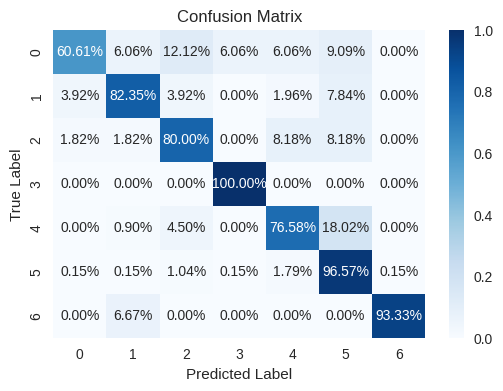

Test Sensitivity: 0.9545, Test Specificity: 0.9091


<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


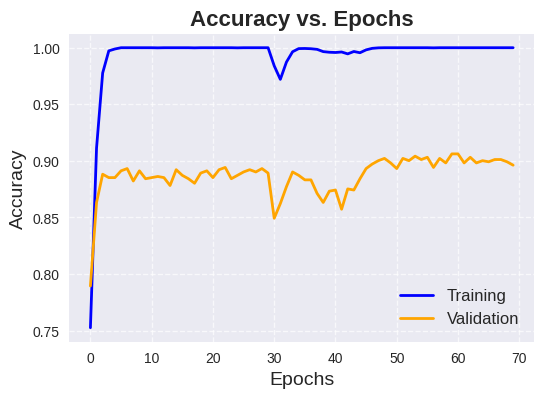

<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


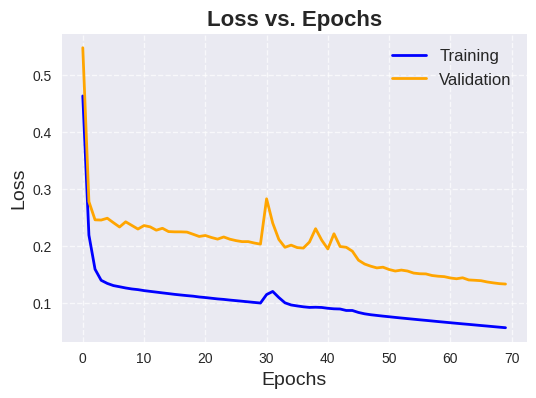

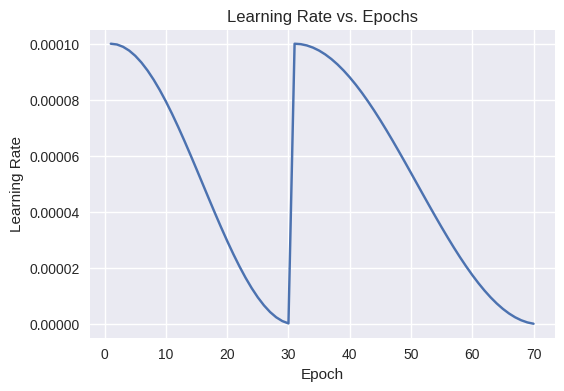

Extracting Features:   0%|          | 0/71 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 71/120, Learning Rate: 0.0001


Epoch 71/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0589, Train Accuracy: 0.9951, Train Precision: 0.9951, Train Recall: 0.9951, Train F1 Score: 0.9951


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1744, Validation Accuracy: 0.8633, Validation Precision: 0.8647, Validation Recall: 0.8633, Validation F1 Score: 0.8578
Epoch 72/120, Learning Rate: 9.990134628777144e-05


Epoch 72/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0638, Train Accuracy: 0.9846, Train Precision: 0.9846, Train Recall: 0.9846, Train F1 Score: 0.9846


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1609, Validation Accuracy: 0.8603, Validation Precision: 0.8583, Validation Recall: 0.8603, Validation F1 Score: 0.8558
Epoch 73/120, Learning Rate: 9.960577449221733e-05


Epoch 73/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0598, Train Accuracy: 0.9901, Train Precision: 0.9901, Train Recall: 0.9901, Train F1 Score: 0.9901


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1488, Validation Accuracy: 0.8752, Validation Precision: 0.8781, Validation Recall: 0.8752, Validation F1 Score: 0.8762
Epoch 74/120, Learning Rate: 9.91144511001808e-05


Epoch 74/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0557, Train Accuracy: 0.9950, Train Precision: 0.9950, Train Recall: 0.9950, Train F1 Score: 0.9950


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1514, Validation Accuracy: 0.8653, Validation Precision: 0.8674, Validation Recall: 0.8653, Validation F1 Score: 0.8638
Epoch 75/120, Learning Rate: 9.84293151406259e-05


Epoch 75/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0524, Train Accuracy: 0.9982, Train Precision: 0.9982, Train Recall: 0.9982, Train F1 Score: 0.9982


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1407, Validation Accuracy: 0.8812, Validation Precision: 0.8771, Validation Recall: 0.8812, Validation F1 Score: 0.8768
Epoch 76/120, Learning Rate: 9.75530705321762e-05


Epoch 76/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0506, Train Accuracy: 0.9992, Train Precision: 0.9992, Train Recall: 0.9992, Train F1 Score: 0.9992


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1420, Validation Accuracy: 0.8842, Validation Precision: 0.8795, Validation Recall: 0.8842, Validation F1 Score: 0.8785
Epoch 77/120, Learning Rate: 9.648917541198312e-05


Epoch 77/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0496, Train Accuracy: 0.9987, Train Precision: 0.9987, Train Recall: 0.9987, Train F1 Score: 0.9987


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1356, Validation Accuracy: 0.8892, Validation Precision: 0.8843, Validation Recall: 0.8892, Validation F1 Score: 0.8844
Epoch 78/120, Learning Rate: 9.524182848803865e-05


Epoch 78/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0499, Train Accuracy: 0.9966, Train Precision: 0.9966, Train Recall: 0.9966, Train F1 Score: 0.9966


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1300, Validation Accuracy: 0.8882, Validation Precision: 0.8870, Validation Recall: 0.8882, Validation F1 Score: 0.8866
Epoch 79/120, Learning Rate: 9.381595246879295e-05


Epoch 79/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0477, Train Accuracy: 0.9987, Train Precision: 0.9987, Train Recall: 0.9987, Train F1 Score: 0.9987


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1331, Validation Accuracy: 0.8752, Validation Precision: 0.8799, Validation Recall: 0.8752, Validation F1 Score: 0.8757
Epoch 80/120, Learning Rate: 9.221717463547324e-05


Epoch 80/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0464, Train Accuracy: 0.9990, Train Precision: 0.9990, Train Recall: 0.9990, Train F1 Score: 0.9990


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1327, Validation Accuracy: 0.8802, Validation Precision: 0.8750, Validation Recall: 0.8802, Validation F1 Score: 0.8752
Epoch 81/120, Learning Rate: 9.04518046337755e-05


Epoch 81/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0459, Train Accuracy: 0.9979, Train Precision: 0.9979, Train Recall: 0.9979, Train F1 Score: 0.9979


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1431, Validation Accuracy: 0.8723, Validation Precision: 0.8716, Validation Recall: 0.8723, Validation F1 Score: 0.8687
Epoch 82/120, Learning Rate: 8.852680957257558e-05


Epoch 82/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0448, Train Accuracy: 0.9982, Train Precision: 0.9982, Train Recall: 0.9982, Train F1 Score: 0.9982


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1439, Validation Accuracy: 0.8723, Validation Precision: 0.8692, Validation Recall: 0.8723, Validation F1 Score: 0.8631
Epoch 83/120, Learning Rate: 8.644978652793345e-05


Epoch 83/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0434, Train Accuracy: 0.9984, Train Precision: 0.9984, Train Recall: 0.9984, Train F1 Score: 0.9984


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1342, Validation Accuracy: 0.8802, Validation Precision: 0.8822, Validation Recall: 0.8802, Validation F1 Score: 0.8810
Epoch 84/120, Learning Rate: 8.422893256090478e-05


Epoch 84/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0436, Train Accuracy: 0.9968, Train Precision: 0.9968, Train Recall: 0.9968, Train F1 Score: 0.9968


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1364, Validation Accuracy: 0.8802, Validation Precision: 0.8761, Validation Recall: 0.8802, Validation F1 Score: 0.8736
Epoch 85/120, Learning Rate: 8.187301236748573e-05


Epoch 85/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0416, Train Accuracy: 0.9982, Train Precision: 0.9982, Train Recall: 0.9982, Train F1 Score: 0.9982


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1382, Validation Accuracy: 0.8772, Validation Precision: 0.8796, Validation Recall: 0.8772, Validation F1 Score: 0.8717
Epoch 86/120, Learning Rate: 7.939132368836219e-05


Epoch 86/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0403, Train Accuracy: 0.9987, Train Precision: 0.9987, Train Recall: 0.9987, Train F1 Score: 0.9987


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1292, Validation Accuracy: 0.8862, Validation Precision: 0.8824, Validation Recall: 0.8862, Validation F1 Score: 0.8830
Epoch 87/120, Learning Rate: 7.679366061497492e-05


Epoch 87/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0386, Train Accuracy: 0.9994, Train Precision: 0.9994, Train Recall: 0.9994, Train F1 Score: 0.9994


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1360, Validation Accuracy: 0.8673, Validation Precision: 0.8740, Validation Recall: 0.8673, Validation F1 Score: 0.8698
Epoch 88/120, Learning Rate: 7.409027493671524e-05


Epoch 88/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0386, Train Accuracy: 0.9976, Train Precision: 0.9976, Train Recall: 0.9976, Train F1 Score: 0.9976


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1241, Validation Accuracy: 0.8932, Validation Precision: 0.8921, Validation Recall: 0.8932, Validation F1 Score: 0.8919
Epoch 89/120, Learning Rate: 7.12918356817958e-05


Epoch 89/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0383, Train Accuracy: 0.9966, Train Precision: 0.9966, Train Recall: 0.9966, Train F1 Score: 0.9966


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1342, Validation Accuracy: 0.8703, Validation Precision: 0.8664, Validation Recall: 0.8703, Validation F1 Score: 0.8645
Epoch 90/120, Learning Rate: 6.840938701147047e-05


Epoch 90/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0365, Train Accuracy: 0.9984, Train Precision: 0.9984, Train Recall: 0.9984, Train F1 Score: 0.9984


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1239, Validation Accuracy: 0.8822, Validation Precision: 0.8796, Validation Recall: 0.8822, Validation F1 Score: 0.8787
Epoch 91/120, Learning Rate: 6.545430463377548e-05


Epoch 91/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0345, Train Accuracy: 0.9998, Train Precision: 0.9998, Train Recall: 0.9998, Train F1 Score: 0.9998


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1150, Validation Accuracy: 0.8922, Validation Precision: 0.8901, Validation Recall: 0.8922, Validation F1 Score: 0.8896
Epoch 92/120, Learning Rate: 6.243825090880689e-05


Epoch 92/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0332, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1078, Validation Accuracy: 0.8932, Validation Precision: 0.8933, Validation Recall: 0.8932, Validation F1 Score: 0.8928
Epoch 93/120, Learning Rate: 5.93731288227133e-05


Epoch 93/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0321, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1054, Validation Accuracy: 0.9012, Validation Precision: 0.8984, Validation Recall: 0.9012, Validation F1 Score: 0.8990
Epoch 94/120, Learning Rate: 5.6271035012047397e-05


Epoch 94/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0310, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1043, Validation Accuracy: 0.9032, Validation Precision: 0.9001, Validation Recall: 0.9032, Validation F1 Score: 0.9006
Epoch 95/120, Learning Rate: 5.3144212023868024e-05


Epoch 95/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0300, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1059, Validation Accuracy: 0.8962, Validation Precision: 0.8967, Validation Recall: 0.8962, Validation F1 Score: 0.8941
Epoch 96/120, Learning Rate: 5.0005e-05


Epoch 96/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0290, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1025, Validation Accuracy: 0.9052, Validation Precision: 0.9025, Validation Recall: 0.9052, Validation F1 Score: 0.9032
Epoch 97/120, Learning Rate: 4.6865787976131975e-05


Epoch 97/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0280, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0988, Validation Accuracy: 0.9072, Validation Precision: 0.9049, Validation Recall: 0.9072, Validation F1 Score: 0.9057
Best model updated based on validation accuracy
Epoch 98/120, Learning Rate: 4.373896498795261e-05


Epoch 98/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0269, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0975, Validation Accuracy: 0.9122, Validation Precision: 0.9104, Validation Recall: 0.9122, Validation F1 Score: 0.9109
Best model updated based on validation accuracy
Epoch 99/120, Learning Rate: 4.06368711772867e-05


Epoch 99/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0259, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.1016, Validation Accuracy: 0.8992, Validation Precision: 0.8990, Validation Recall: 0.8992, Validation F1 Score: 0.8957
Epoch 100/120, Learning Rate: 3.7571749091193084e-05


Epoch 100/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0248, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0983, Validation Accuracy: 0.9062, Validation Precision: 0.9036, Validation Recall: 0.9062, Validation F1 Score: 0.9041
Epoch 101/120, Learning Rate: 3.4555695366224525e-05


Epoch 101/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0238, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0957, Validation Accuracy: 0.9032, Validation Precision: 0.9012, Validation Recall: 0.9032, Validation F1 Score: 0.9017
Epoch 102/120, Learning Rate: 3.160061298852955e-05


Epoch 102/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0227, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0957, Validation Accuracy: 0.9032, Validation Precision: 0.9011, Validation Recall: 0.9032, Validation F1 Score: 0.9012
Epoch 103/120, Learning Rate: 2.8718164318204197e-05


Epoch 103/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0216, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0947, Validation Accuracy: 0.9052, Validation Precision: 0.9027, Validation Recall: 0.9052, Validation F1 Score: 0.9033
Epoch 104/120, Learning Rate: 2.5919725063284742e-05


Epoch 104/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0206, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0934, Validation Accuracy: 0.9072, Validation Precision: 0.9050, Validation Recall: 0.9072, Validation F1 Score: 0.9051
Epoch 105/120, Learning Rate: 2.3216339385025057e-05


Epoch 105/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0195, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0930, Validation Accuracy: 0.9052, Validation Precision: 0.9026, Validation Recall: 0.9052, Validation F1 Score: 0.9033
Epoch 106/120, Learning Rate: 2.0618676311637815e-05


Epoch 106/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0184, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0915, Validation Accuracy: 0.9062, Validation Precision: 0.9033, Validation Recall: 0.9062, Validation F1 Score: 0.9039
Epoch 107/120, Learning Rate: 1.8136987632514258e-05


Epoch 107/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0174, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0912, Validation Accuracy: 0.9042, Validation Precision: 0.9009, Validation Recall: 0.9042, Validation F1 Score: 0.9015
Epoch 108/120, Learning Rate: 1.578106743909521e-05


Epoch 108/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0163, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0915, Validation Accuracy: 0.9082, Validation Precision: 0.9057, Validation Recall: 0.9082, Validation F1 Score: 0.9060
Epoch 109/120, Learning Rate: 1.356021347206654e-05


Epoch 109/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0152, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0898, Validation Accuracy: 0.9092, Validation Precision: 0.9065, Validation Recall: 0.9092, Validation F1 Score: 0.9069
Epoch 110/120, Learning Rate: 1.148319042742442e-05


Epoch 110/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0141, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0902, Validation Accuracy: 0.9062, Validation Precision: 0.9032, Validation Recall: 0.9062, Validation F1 Score: 0.9037
Epoch 111/120, Learning Rate: 9.558195366224506e-06


Epoch 111/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0129, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0885, Validation Accuracy: 0.9072, Validation Precision: 0.9045, Validation Recall: 0.9072, Validation F1 Score: 0.9051
Epoch 112/120, Learning Rate: 7.792825364526766e-06


Epoch 112/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0118, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0890, Validation Accuracy: 0.9022, Validation Precision: 0.8992, Validation Recall: 0.9022, Validation F1 Score: 0.9000
Epoch 113/120, Learning Rate: 6.1940475312070395e-06


Epoch 113/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0106, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0891, Validation Accuracy: 0.9032, Validation Precision: 0.9002, Validation Recall: 0.9032, Validation F1 Score: 0.9001
Epoch 114/120, Learning Rate: 4.768171511961362e-06


Epoch 114/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0095, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0893, Validation Accuracy: 0.9022, Validation Precision: 0.8997, Validation Recall: 0.9022, Validation F1 Score: 0.9000
Epoch 115/120, Learning Rate: 3.5208245880168734e-06


Epoch 115/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0083, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0873, Validation Accuracy: 0.9072, Validation Precision: 0.9042, Validation Recall: 0.9072, Validation F1 Score: 0.9047
Epoch 116/120, Learning Rate: 2.456929467823799e-06


Epoch 116/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0071, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0890, Validation Accuracy: 0.9022, Validation Precision: 0.8997, Validation Recall: 0.9022, Validation F1 Score: 0.9003
Epoch 117/120, Learning Rate: 1.5806848593740944e-06


Epoch 117/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0059, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0889, Validation Accuracy: 0.9062, Validation Precision: 0.9041, Validation Recall: 0.9062, Validation F1 Score: 0.9046
Epoch 118/120, Learning Rate: 8.955488998192071e-07


Epoch 118/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0047, Train Accuracy: 0.9999, Train Precision: 0.9999, Train Recall: 0.9999, Train F1 Score: 0.9999


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0873, Validation Accuracy: 0.9042, Validation Precision: 0.9010, Validation Recall: 0.9042, Validation F1 Score: 0.9015
Epoch 119/120, Learning Rate: 4.0422550778268403e-07


Epoch 119/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0035, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0847, Validation Accuracy: 0.9092, Validation Precision: 0.9060, Validation Recall: 0.9092, Validation F1 Score: 0.9067
Epoch 120/120, Learning Rate: 1.0865371222856339e-07


Epoch 120/120:   0%|          | 0/71 [00:00<?, ?it/s]

Train Loss: 0.0023, Train Accuracy: 1.0000, Train Precision: 1.0000, Train Recall: 1.0000, Train F1 Score: 1.0000


Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Validation Loss: 0.0845, Validation Accuracy: 0.9082, Validation Precision: 0.9052, Validation Recall: 0.9082, Validation F1 Score: 0.9056
Snapshot 2 saved


Testing:   0%|          | 0/8 [00:00<?, ?it/s]

Test Loss: 0.0733, Test Accuracy: 0.9122, Test Precision: 0.9104, Test Recall: 0.9122, Test F1 Score: 0.9109
Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73        33
           1       0.91      0.82      0.87        51
           2       0.81      0.80      0.81       110
           3       0.91      0.83      0.87        12
           4       0.82      0.77      0.80       111
           5       0.95      0.97      0.96       670
           6       0.88      0.93      0.90        15

    accuracy                           0.91      1002
   macro avg       0.86      0.83      0.85      1002
weighted avg       0.91      0.91      0.91      1002



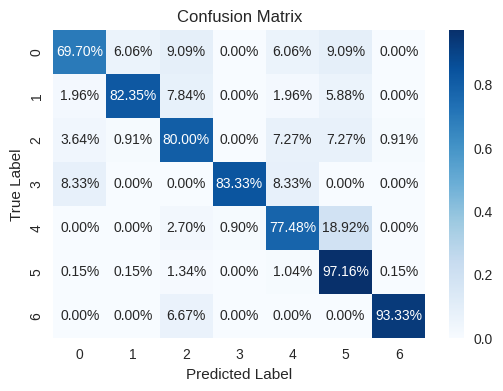

Test Sensitivity: 0.9767, Test Specificity: 0.9200


<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


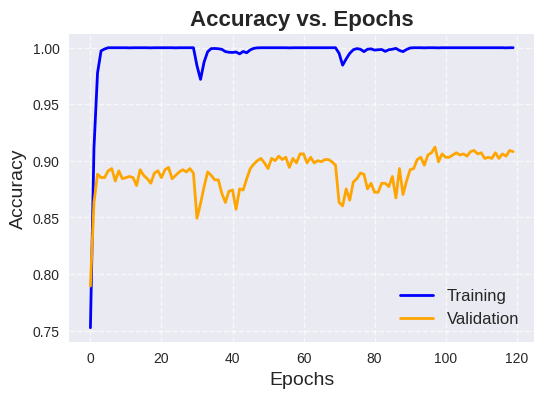

<ipython-input-11-b4d69ca1d043>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plot style


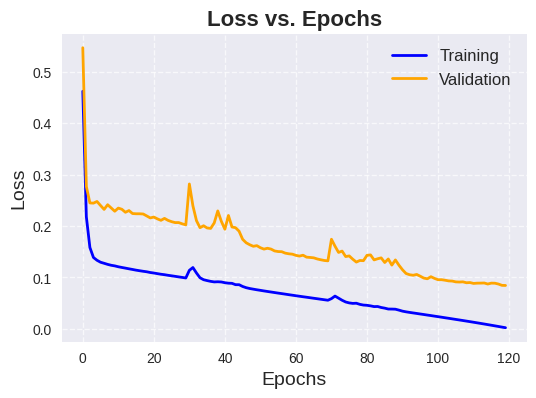

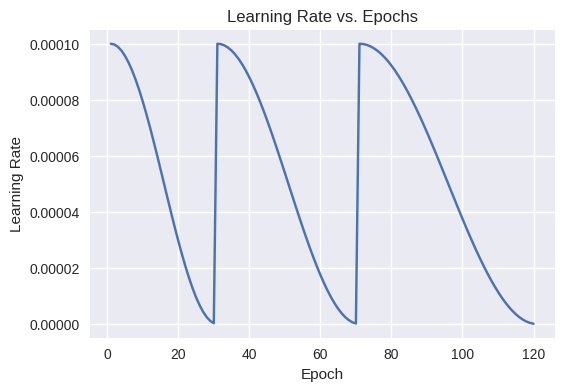

Extracting Features:   0%|          | 0/71 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

Extracting Features:   0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
ensemble_models = snapshot_ensemble(train_loader, val_loader, test_loader, num_classes, device)

In [16]:
import torch
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


In [17]:
# Define paths
train_feature_paths = [
    "/kaggle/working/snapshot_0_train_features.pth",
    "/kaggle/working/snapshot_1_train_features.pth",
    "/kaggle/working/snapshot_2_train_features.pth"
]

test_feature_paths = [
    "/kaggle/working/snapshot_0_test_features.pth",
    "/kaggle/working/snapshot_1_test_features.pth",
    "/kaggle/working/snapshot_2_test_features.pth"
]


# ****Feature Extraction, Concatenation and Save it into CSV file format****

In [18]:
import numpy as np
import torch

def load_features(paths):
    """Load and horizontally concatenate features from multiple files."""
    combined_features = []
    for path in paths:
        data = torch.load(path)
        features = data['features']
        if isinstance(features, torch.Tensor):
            features = features.numpy()
        # Exclude the last column, which contains labels
        features = features[:, :-1]
        combined_features.append(features)
    # Horizontally concatenate features (not vertically)
    concatenated_features = np.concatenate(combined_features, axis=1)
    return concatenated_features

# Load features from paths and concatenate with labels separately
train_features = load_features(train_feature_paths)
test_features = load_features(test_feature_paths)

# Load labels separately
train_labels = torch.load("/kaggle/working/snapshot_2_train_features.pth")['labels']
test_labels = torch.load("/kaggle/working/snapshot_2_test_features.pth")['labels']

# Print the shape of the features
print("Shape of concatenated train features:", train_features.shape)
print("Shape of concatenated test features:", test_features.shape)

# Save features and labels to CSV files
train_data_with_labels = np.column_stack((train_features, train_labels))
test_data_with_labels = np.column_stack((test_features, test_labels))

np.savetxt('train_data_with_labels_Ham10K.csv', train_data_with_labels, delimiter=',')
np.savetxt('test_data_with_labels_Ham10K.csv', test_data_with_labels, delimiter=',')


<ipython-input-18-5f001c331952>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path)
<ipython-input-18-5f001c331952>:24: FutureWarning: You are using `to

Shape of concatenated train features: (9013, 765)
Shape of concatenated test features: (1002, 765)


In [19]:
import numpy as np

# Load labels from CSV files
train_labels = np.loadtxt('/kaggle/working/train_data_with_labels_Ham10K.csv', delimiter=',', usecols=-1)
test_labels = np.loadtxt('/kaggle/working/test_data_with_labels_Ham10K.csv', delimiter=',', usecols=-1)

# Calculate the frequency of each class in the train set
train_classes, train_counts = np.unique(train_labels, return_counts=True)
print("Train set class frequencies:")
for cls, count in zip(train_classes, train_counts):
    print(f"Class {int(cls)}: {count} samples")

# Calculate the frequency of each class in the test set
test_classes, test_counts = np.unique(test_labels, return_counts=True)
print("\nTest set class frequencies:")
for cls, count in zip(test_classes, test_counts):
    print(f"Class {int(cls)}: {count} samples")


Train set class frequencies:
Class 0: 294 samples
Class 1: 463 samples
Class 2: 989 samples
Class 3: 103 samples
Class 4: 1002 samples
Class 5: 6035 samples
Class 6: 127 samples

Test set class frequencies:
Class 0: 33 samples
Class 1: 51 samples
Class 2: 110 samples
Class 3: 12 samples
Class 4: 111 samples
Class 5: 670 samples
Class 6: 15 samples


# ****Feature Selection Using SelectKBest Method:****

In [20]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

# Load data from CSV files with labels
train_data = np.loadtxt('/kaggle/working/train_data_with_labels_Ham10K.csv', delimiter=',')
test_data = np.loadtxt('/kaggle/working/test_data_with_labels_Ham10K.csv', delimiter=',')

X_train = train_data[:, :-1]  # Features
y_train = train_data[:, -1]   # Labels

X_test = test_data[:, :-1]   # Features
y_test = test_data[:, -1]    # Labels

def feature_selection(X_train, y_train, X_test, k=5):
    """Perform feature selection using SelectKBest with ANOVA F-value."""
    # Initialize SelectKBest with the desired number of features to select
    selector = SelectKBest(f_classif, k=k)
    
    # Fit SelectKBest on the training data
    selector.fit(X_train, y_train)
    
    # Get indices of selected features
    selected_feature_indices = selector.get_support(indices=True)
    
    return selected_feature_indices

# Initialize lists to store accuracies
svm_accuracies = []
rf_accuracies = []

with tqdm(total=X_train.shape[1], desc="Feature Selection Progress") as pbar:
    for k in range(1, X_train.shape[1] + 1):
        selected_feature_indices_train = feature_selection(X_train, y_train, X_test, k=k)
        X_train_selected = X_train[:, selected_feature_indices_train]
        X_test_selected = X_test[:, selected_feature_indices_train]

        # Feature scaling
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_selected)
        X_test_scaled = scaler.transform(X_test_selected)

        # Random Forest
        rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
        rf_classifier.fit(X_train_scaled, y_train)
        rf_predictions = rf_classifier.predict(X_test_scaled)
        rf_accuracy = accuracy_score(y_test, rf_predictions)
        rf_accuracies.append(rf_accuracy)

        # Support Vector Machine
        svm_classifier = SVC(kernel='rbf', random_state=42)
        svm_classifier.fit(X_train_scaled, y_train)
        svm_predictions = svm_classifier.predict(X_test_scaled)
        svm_accuracy = accuracy_score(y_test, svm_predictions)
        svm_accuracies.append(svm_accuracy)
        
        pbar.update(1)

# Print accuracies for all k values
print("SVM Accuracies for all k values:")
for k, accuracy in enumerate(svm_accuracies, start=1):
    print(f"k={k}: {accuracy}")

print("\nRandom Forest Accuracies for all k values:")
for k, accuracy in enumerate(rf_accuracies, start=1):
    print(f"k={k}: {accuracy}")

# Find the k value with the highest accuracy for both SVM and RF
best_k_svm = np.argmax(svm_accuracies) + 1
best_accuracy_svm = svm_accuracies[best_k_svm - 1]

best_k_rf = np.argmax(rf_accuracies) + 1
best_accuracy_rf = rf_accuracies[best_k_rf - 1]

print("\nBest SVM Accuracy:", best_accuracy_svm, "achieved with k =", best_k_svm)
print("Best RF Accuracy:", best_accuracy_rf, "achieved with k =", best_k_rf)

# Select the features for the best accuracies
selected_feature_indices_svm = feature_selection(X_train, y_train, X_test, k=best_k_svm)
X_train_selected_svm = X_train[:, selected_feature_indices_svm]
X_test_selected_svm = X_test[:, selected_feature_indices_svm]

selected_feature_indices_rf = feature_selection(X_train, y_train, X_test, k=best_k_rf)
X_train_selected_rf = X_train[:, selected_feature_indices_rf]
X_test_selected_rf = X_test[:, selected_feature_indices_rf]

# Feature scaling
scaler = StandardScaler()
X_train_scaled_svm = scaler.fit_transform(X_train_selected_svm)
X_test_scaled_svm = scaler.transform(X_test_selected_svm)

X_train_scaled_rf = scaler.fit_transform(X_train_selected_rf)
X_test_scaled_rf = scaler.transform(X_test_selected_rf)

# Train SVM with the best k
best_svm_classifier = SVC(kernel='rbf', random_state=42)
best_svm_classifier.fit(X_train_scaled_svm, y_train)
svm_predictions = best_svm_classifier.predict(X_test_scaled_svm)

# Train RF with the best k
best_rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)
best_rf_classifier.fit(X_train_scaled_rf, y_train)
rf_predictions = best_rf_classifier.predict(X_test_scaled_rf)

# Print classification reports
print("\nClassification Report for Best SVM:")
svm_report = classification_report(y_test, svm_predictions, output_dict=True)
for key, value in svm_report.items():
    if key != 'accuracy':
        print(f"{key}: {value['precision']:.4f}, {value['recall']:.4f}, {value['f1-score']:.4f}, {value['support']}")

print("\nClassification Report for Best Random Forest:")
rf_report = classification_report(y_test, rf_predictions, output_dict=True)
for key, value in rf_report.items():
    if key != 'accuracy':
        print(f"{key}: {value['precision']:.4f}, {value['recall']:.4f}, {value['f1-score']:.4f}, {value['support']}")


Feature Selection Progress: 100%|██████████| 765/765 [18:24<00:00,  1.44s/it]


SVM Accuracies for all k values:
k=1: 0.7365269461077845
k=2: 0.8473053892215568
k=3: 0.8692614770459082
k=4: 0.8822355289421158
k=5: 0.8942115768463074
k=6: 0.9011976047904192
k=7: 0.9051896207584831
k=8: 0.9041916167664671
k=9: 0.9051896207584831
k=10: 0.9031936127744511
k=11: 0.9051896207584831
k=12: 0.9051896207584831
k=13: 0.9041916167664671
k=14: 0.9051896207584831
k=15: 0.906187624750499
k=16: 0.906187624750499
k=17: 0.906187624750499
k=18: 0.906187624750499
k=19: 0.908183632734531
k=20: 0.907185628742515
k=21: 0.906187624750499
k=22: 0.906187624750499
k=23: 0.906187624750499
k=24: 0.907185628742515
k=25: 0.907185628742515
k=26: 0.907185628742515
k=27: 0.907185628742515
k=28: 0.907185628742515
k=29: 0.907185628742515
k=30: 0.907185628742515
k=31: 0.906187624750499
k=32: 0.908183632734531
k=33: 0.908183632734531
k=34: 0.908183632734531
k=35: 0.908183632734531
k=36: 0.908183632734531
k=37: 0.908183632734531
k=38: 0.908183632734531
k=39: 0.908183632734531
k=40: 0.908183632734531
k=